<a href="https://colab.research.google.com/github/adasey/MachineLearn/blob/main/first_steps_with_tensor_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 텐서플로우 첫걸음

 **학습 목표:**
  * 텐서플로우의 기초 개념을 학습한다
  * 텐서플로우의 `LinearRegressor` 클래스를 사용하여 입력 특성 하나를 기반으로 지역별 주택 가격 중앙값을 예측한다
  * 평균 제곱근 오차(RMSE)를 사용하여 모델 예측의 정확성을 평가한다
  * 초매개변수를 조정하여 모델의 정확성을 개선한다

 데이터의 출처는 1990년 캘리포니아 인구조사 자료입니다.

 ## 설정
첫 번째 셀에서 필요한 라이브러리를 로드하겠습니다.

In [9]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

 다음으로는 데이터 세트를 로드합니다.

In [10]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

 확률적 경사하강법의 성능에 악영향을 줄 수 있는 의도치 않은 정렬 효과를 방지하고자 데이터를 무작위로 추출하겠습니다. 또한 일반적으로 사용하는 학습률 범위에서 보다 쉽게 학습할 수 있도록 `median_house_value`를 천 단위로 조정하겠습니다.

In [11]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
607,-117.0,33.3,14.0,1088.0,209.0,601.0,193.0,3.8,243.8
8150,-118.4,34.0,24.0,3832.0,949.0,1613.0,893.0,4.0,477.3
888,-117.1,32.8,7.0,13703.0,2352.0,4446.0,1856.0,6.4,260.6
1237,-117.1,33.1,16.0,1129.0,198.0,758.0,178.0,5.0,174.6
15412,-122.3,37.9,46.0,1647.0,376.0,854.0,355.0,2.9,144.8
...,...,...,...,...,...,...,...,...,...
16646,-122.7,38.5,25.0,2696.0,496.0,1296.0,514.0,4.1,179.2
1341,-117.2,32.7,27.0,2335.0,604.0,982.0,590.0,3.2,261.5
15286,-122.3,37.9,41.0,2214.0,550.0,1213.0,568.0,2.3,153.1
3769,-117.9,33.6,31.0,1291.0,356.0,1252.0,373.0,2.7,185.4


 ## 데이터 조사

데이터를 본격적으로 다루기 전에 잠시 살펴보는 것이 좋습니다.

각 열에 대해 예의 개수, 평균, 표준편차, 최대값, 최소값, 다양한 분위 등 몇 가지 유용한 통계를 간단히 요약하여 출력해 보겠습니다.

In [12]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


 ## 첫 번째 모델 만들기

이 실습에서는 라벨(타겟이라고도 함) 역할을 하는 `median_house_value`에 대한 예측을 시도합니다. 입력 특성으로는 `total_rooms`를 사용합니다.

**참고:** 데이터는 지역 단위이므로 이 특성은 해당 지역의 전체 방 수를 나타냅니다.

모델을 학습시키려면 텐서플로우 [Estimator](https://www.tensorflow.org/get_started/estimator) API가 제공하는 [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) 인터페이스를 사용합니다. 이 API는 저수준 모델 작업을 알아서 처리하고 모델 학습, 평가, 추론을 수행하는 데 편리하게 사용되는 메소드를 노출합니다.

 ### 1단계: 특성 정의 및 특성 열 구성

 학습 데이터를 텐서플로우로 가져오려면 각 특성에 들어있는 데이터 유형을 지정해야 합니다. 이 실습과 이후 실습에서는 주로 2가지 데이터 유형을 사용합니다.

* **범주형 데이터**: 텍스트로 이루어진 데이터입니다. 이 실습의 주택 데이터 세트는 범주형 데이터를 포함하지 않지만 주택 양식, 부동산 광고 문구 등의 예를 보게 될 수도 있습니다.

* **수치 데이터**: 정수 또는 부동 소수점 숫자이며 숫자로 취급하려는 데이터입니다. 이후에도 설명하겠지만, 우편번호 등의 수치 데이터는 범주형으로 취급하는 경우도 있습니다.

텐서플로우에서 특성의 데이터 유형을 지정하려면 **특성 열**이라는 구조체를 사용합니다. 특성 열은 특성 데이터에 대한 설명만 저장하며 특성 데이터 자체는 포함하지 않습니다.

우선은 `total_rooms`라는 수치 입력 데이터 하나만 사용하겠습니다. 다음 코드에서는 `california_housing_dataframe`에서 `total_rooms` 데이터를 추출하고 `numeric_column`으로 특성 열을 정의하여 데이터가 숫자임을 지정합니다.

In [13]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

 **참고:** `total_rooms` 데이터는 1차원 배열(각 지역의 전체 방 수로 이루어진 목록) 형태입니다. 이는 `numeric_column`의 기본 형태이므로 인수로 전달할 필요가 없습니다.

 ### 2단계: 타겟 정의

 다음으로는 타겟인 `median_house_value`를 정의합니다. 이 데이터도 `california_housing_dataframe`에서 가져옵니다.

In [14]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]

 ### 3단계: LinearRegressor 구성

 다음으로는 LinearRegressor를 사용하여 선형 회귀 모델을구성합니다. 미니 배치 확률적 경사하강법(SGD)을 구현하는 `GradientDescentOptimizer`를 사용하여 이 모델을 학습시킬 것입니다. `learning_rate` 인수는 경사 단계의 크기를 조절합니다.

**참고:** 안전을 위해 옵티마이저에 `clip_gradients_by_norm`을 통해 [경사 제한](https://developers.google.com/machine-learning/glossary/#gradient_clipping)을 적용합니다. 경사 제한은 학습 중에 경사가 너무 커져서 경사하강법이 실패하는 경우가 나타나지 않도록 제한합니다. 

In [15]:
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

 ### 4단계: 입력 함수 정의

 캘리포니아 주택 데이터를 `LinearRegressor`로 가져오려면 텐서플로우에 데이터 전처리 방법 및 모델 학습 중의 일괄 처리, 셔플, 반복 방법을 알려주는 입력 함수를 정의해야 합니다.

우선 *pandas* 특성 데이터를 NumPy 배열의 dict로 변환합니다. 그런 다음 텐서플로우의 [Dataset API](https://www.tensorflow.org/programmers_guide/datasets)를 사용하여 이 데이터로부터 데이터 세트 개체를 생성하고 `batch_size` 크기의 배치로 나누어 지정한 세대 수(num_epochs)만큼 반복합니다.

**참고:** 기본값인 `num_epochs=None`을 `repeat()`에 전달하면 입력 데이터가 무한정 반복됩니다.

다음으로, `shuffle`을 `True`로 설정하면 학습 중에 데이터가 모델에 무작위로 전달되도록 데이터가 뒤섞입니다. `buffer_size` 인수는 `shuffle`에서 무작위로 추출할 데이터 세트의 크기를 지정합니다.

마지막으로 입력 함수에서 데이터 세트에 대한 반복자를 만들고 다음 데이터 배치를 LinearRegressor에 반환합니다.

In [16]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 **참고:** 이후 실습에도 이 입력 함수를 계속 사용합니다. 입력 함수 및 `Dataset` API에 대한 자세한 내용은 [텐서플로우 프로그래머 가이드](https://www.tensorflow.org/programmers_guide/datasets)를 참조하세요.

 ### 5단계: 모델 학습

 이제 linear_regressor로부터 train()을 호출하여 모델을 학습시킬 수 있습니다. `my_feature` 및 `target`을 인수로 전달할 수 있도록 `my_input_fn`을 `lambda`에 래핑하겠습니다. 자세한 내용은 [텐서플로우 입력 함수 가이드](https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model)를 참조하세요. 처음에는 100단계만 학습하려고 합니다.

In [17]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

 ### 6단계: 모델 평가

 모델이 학습 중에 학습 데이터에 얼마나 맞춰졌는지 확인하기 위해 학습 데이터로 예측을 실행하겠습니다.

**참고:** 학습 오차는 모델이 학습 데이터에 얼마나 맞춰졌는지를 나타내는 척도이지만 모델이 **_새 데이터로 일반화_**되는 정도를 측정하지는 **_않습니다._** 이후 실습에서는 모델의 일반화 능력을 평가할 수 있도록 데이터를 분할하는 방법을 알아봅니다.


In [18]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


 우수한 모델인가요? 이 오차가 얼마나 큰지 어떻게 판단할 수 있을까요?

평균 제곱 오차(MSE)는 해석하기가 어려울 수 있으므로 평균 제곱근 오차(RMSE)를 대신 참고하는 경우가 많습니다. RMSE의 장점은 원래 타겟과 동일한 척도로 해석할 수 있다는 것입니다.

RMSE를 타겟의 최소값과 최대값의 차와 비교해 보겠습니다.

In [19]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


 오차 범위가 타겟 값 범위의 거의 절반에 달합니다. 오차를 이보다 줄일 수 있을까요?

이 질문이야말로 모든 모델 개발자들의 숙제입니다. 모델 오차를 줄이는 몇 가지 기본적인 전략을 수립해 보겠습니다.

가장 처음에 할 수 있는 일은 전반적 요약 통계를 참조하여 예측과 타겟의 일치율을 조사하는 것입니다.

In [20]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


 이 정보는 유용해 보입니다. 평균 값을 모델의 RMSE와 비교해 보면 어떠한가요? 다양한 분위는 어떠한가요?

학습한 데이터와 선을 시각화할 수도 있습니다. 단일 특성에 대한 선형 회귀는 입력 *x*를 출력 *y*에 매핑하는 직선으로 표현될 수 있습니다.

우선 판독 가능한 산포도를 그릴 수 있도록 균일한 무작위 데이터 샘플을 추출하겠습니다.

In [21]:
sample = california_housing_dataframe.sample(n=300)

 다음으로는 산포도와 함께 모델의 바이어스 항와 특성 가중치를 바탕으로 학습한 선을 그리겠습니다. 이 선은 빨간색으로 표시됩니다.

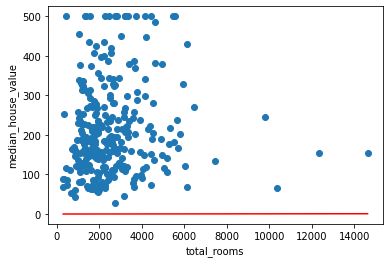

In [22]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

 이 최초 선은 상당히 이탈된 상태입니다. 요약 통계를 다시 조사하여 이 선이 나타내는 정보와 부합하는지 확인해 보세요.

이러한 초기 상태 확인을 통해 훨씬 더 나은 선을 찾을 수 있다는 점을 알 수 있습니다.

 ## 모델 초매개변수 조정
이 실습에서는 편의를 위해 위 모든 코드를 단일 함수에 넣었습니다. 다른 매개변수로 함수를 호출하여 효과를 확인할 수 있습니다.

이 함수에서 균등하게 10개로 나눈 기간으로 학습을 진행하여 모델의 개선을 기간별로 살펴보겠습니다.

각 기간에 대한 학습 손실을 계산하고 그래프로 그리겠습니다. 이를 통해 모델이 수렴되는 시점을 판단하거나 반복이 더 필요함을 확인할 수 있습니다.

또한 모델이 학습한 특성 가중치와 바이어스 항을 시간별로 도식화하겠습니다. 이는 모델이 수렴되는 모습을 확인하는 또 다른 방법입니다.

In [25]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

 ## 작업 1: 180 이하의 RMSE 달성

모델 초매개변수를 조정하여 타겟 분포와 더 잘 일치하도록 손실을 개선합니다.
5분이 지나도록 RMSE를 180 이하로 떨어뜨리지 못한 경우 해결 방법에을 확인하여 가능한 조합을 알아보세요.

Training model...
RMSE (on training data):
  period 00 : 209.12
  period 01 : 187.86
  period 02 : 173.09
  period 03 : 166.74
  period 04 : 166.31
  period 05 : 166.87
  period 06 : 168.03
  period 07 : 168.84
  period 08 : 168.56
  period 09 : 168.85
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,153.4,207.3
std,126.5,116.0
min,0.1,15.0
25%,84.8,119.4
50%,123.4,180.4
75%,182.8,265.0
max,2201.0,500.0


Final RMSE (on training data): 168.85


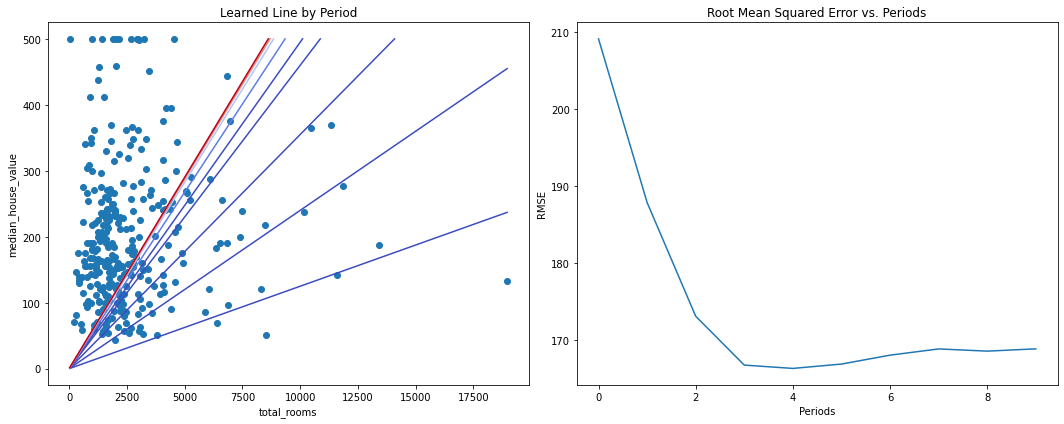

In [33]:
train_model(
    learning_rate=0.00005,
    steps=500,
    batch_size=10
)

 ### 해결 방법

가능한 해결 방법 중 하나를 보려면 아래를 클릭하세요.

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 195.33
  period 04 : 187.23
  period 05 : 180.27
  period 06 : 175.66
  period 07 : 172.08
  period 08 : 169.08
  period 09 : 167.30
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,116.9,207.3
std,96.4,116.0
min,0.1,15.0
25%,64.6,119.4
50%,94.0,180.4
75%,139.3,265.0
max,1676.8,500.0


Final RMSE (on training data): 167.30


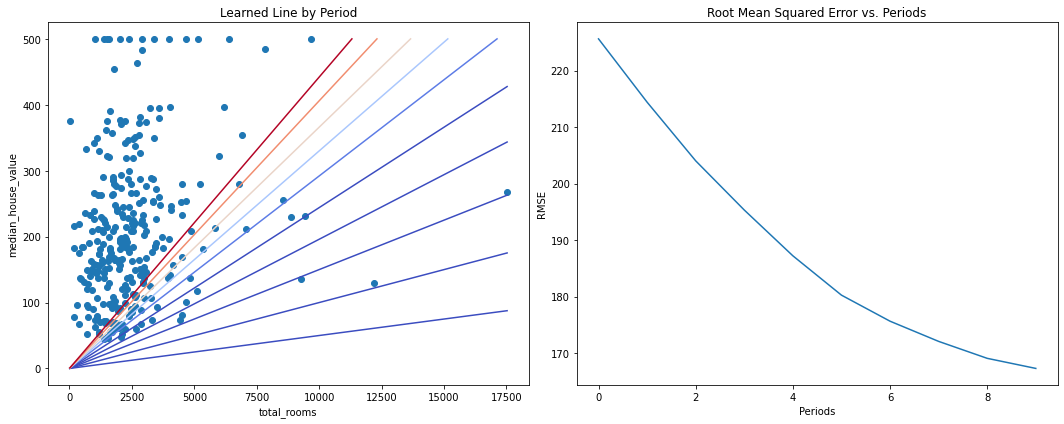

In [31]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

 이는 가능한 조합 중 하나일 뿐이며, 우수한 결과를 내는 다른 설정 조합이 있을 수 있습니다. 일반적으로 이 실습의 목적은 *최상의* 설정을 찾는 것이 아니라 모델 구성을 조정하면 예측 품질에 어떠한 영향을 주는지 감을 잡는 것입니다.

 ### 모델 조정에 대한 표준 휴리스틱이 있는가?

흔히 제기되는 질문입니다. 단적으로 말해, 다양한 초매개변수의 효과는 데이터에 따라 다릅니다. 따라서 알기 쉽고 확고한 규칙은 존재하지 않으며, 실제 데이터로 테스트하는 과정이 필요합니다.

그러나 유용하게 참고할 만한 몇 가지 경험칙이 있습니다.

 * 학습 오차는 점차 감소합니다. 처음에는 급격히 감소하다가 학습이 수렴됨에 따라 결국 한계에 다다릅니다.
 * 학습이 수렴되지 않았다면 더 오래 실행해 보세요.
 * 학습 오차가 너무 천천히 감소하는 경우 학습률을 높이면 더 빨리 감소할 수 있습니다.
   * 학습률이 너무 높다면 정반대 현상이 나타나기도 합니다.
 * 학습 오차가 크게 요동한다면 학습률을 낮춰보세요.
   * 학습률을 낮추면서 단계 수 또는 배치 크기를 늘리면 좋은 결과가 나타나는 경우가 많습니다.
 * 배치 크기가 너무 작아도 불안정성이 나타날 수 있습니다. 처음에는 100, 1000 등의 큰 값을 사용한 후 성능이 악화되지 않는 선까지 낮추세요.

효과는 데이터에 따라 달라지므로 이러한 경험칙을 무조건적으로 따라서는 안 됩니다. 실험과 검증을 항상 반복하세요.

 ## 작업 2: 다른 특성 실험

`total_rooms` 특성을 `population` 특성으로 대체하면 결과가 개선되는지 확인해 봅니다.

이 부분은 최대 5분까지만 진행하시기 바랍니다.

In [35]:
def train_Pm(l_r, steps, b_s, input_feature="population"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=b_s)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=l_r)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

In [40]:
train_Pm (
    l_r = 0.00001,
    steps = 100,
    b_s = 1
)

NameError: ignored

 ### 해결 방법

가능한 해결 방법 중 하나를 보려면 아래를 클릭하세요.

In [ ]:
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)